Fieldtrip: KIT oddball analysis with source localization using beamformer
=========================================================================

Lead authors: Hadi Zaatiti hadi.zaatiti@nyu.edu, Osama Abdullah, osama.abdullah@nyu.edu

This notebook is to be run in MATLAB, while having fieldtrip library installed.
It is a pipeline for processing the `oddball` experiment raw data acquired from KIT-MEG system at NYUAD, run frequency analysis in source space, source localization using Beamformer technique.
The `oddball` code experiment in Psychtoolbox can be found here:

[Oddball experiment page](https://meg-pipeline.readthedocs.io/en/latest/3-experimentdesign/experiments/6-exp-sound.html)

[Oddball PsychToolBox code for KIT system](https://github.com/hzaatiti-NYU/meg-pipeline/blob/bc99896a4e271b902282b1432c12e338060f4fa0/experiments/psychtoolbox/sound/oddball/run_oddball_KIT.m)

Importing data and preprocessing
--------------------------------
The data used in this notebook is hosted on `NYU BOX`. Permissions are given upon request.

- Install the BOX app from [here](https://www.box.com/resources/downloads)
- Set an environment variable with name `MEG_DATA` to the path of the Data folder e.g.,
    - `C:\Users\user_name\Box\MEG\Data`
    - or `C:\Users\user_name\Box\Data`

Each experiment run using the KIT system generates a `.con` and several `.mrk`. Find more details about these files in the other chapters.
In the following setup the variables pointing to your data, headshape and MRI scan.

In [44]:
% Read the environment variable to NYU BOX
MEG_DATA_FOLDER = getenv('MEG_DATA');

% Set path to KIT .con file of sub-03
DATASET_PATH = [MEG_DATA_FOLDER,'oddball\sub-03\meg-kit\sub-03-raw-kit.con'];


% Set path to computed .mat variables, these has been obtained by executing this pipeline and 
% will allow you to skip steps if you wish to execute a particular cell
LOAD_PATH = [MEG_DATA_FOLDER, 'oddball\derivatives\kit_oddball_pipeline\sub-03\'];


% Experiment your own test and save your variables in a folder of your choice, choose the folder where to save your variables
% We will also use it to copy variables from LOAD_PATH and use them in the notebook if needed
SAVE_PATH = 'docs\source\5-pipeline\notebooks\fieldtrip\fieldtrip_oddball_kit_data\';

% It is important that you use T1.mgz instead of orig.mgz as T1.mgz is normalized to [255,255,255] dimension
MRI_FILE         = fullfile([MEG_DATA_FOLDER,'oddball\sub-03\anat\sub-003\sub-003\mri\T1.mgz']);
 
laser_surf      = fullfile([MEG_DATA_FOLDER,'oddball\sub-03\anat\digitized-headshape\sub-03-basic-surface.txt']);
%The cleaned stylus points removes the last three columns (dx, dx, dz) and
%keeps only x,y,z
laser_points    = [MEG_DATA_FOLDER, 'oddball\sub-03\anat\digitized-headshape\sub-03-stylus-cleaned.txt'];
mrkfile1        = [MEG_DATA_FOLDER,'oddball\sub-03\meg-kit\240524-1.mrk'];
mrkfile2        = [MEG_DATA_FOLDER, 'oddball\sub-03\meg-kit\240524-2.mrk'];

try
    cd(SAVE_PATH)
catch
end

C:\Users\hz3752\PycharmProjects\meg-pipeline\docs\source\5-pipeline\notebooks\fieldtrip\fieldtrip_oddball_opm_data


Read the digitized headshape and stylus points.
More information on those in other chapters of the documentation.
The `read_head_shape_laser` function can be found in `pipeline/field_trip_pipelines/matlab_functions`. You can add it to your MATLAB path.

In [21]:
lasershape   = read_head_shape_laser(laser_surf,laser_points);

shape = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []

In [22]:
lasershape   = ft_convert_units(lasershape, 'mm');

In [ ]:
Plot initial digitized headshape.

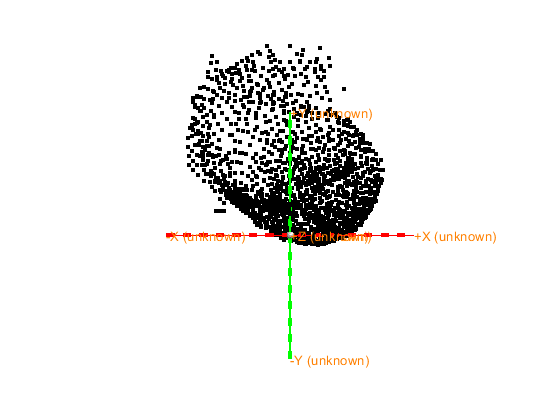

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

In [12]:
ft_determine_coordsys(lasershape, 'interactive', 'no')

Let us now define a coordinate system for the digitized headshape based on the known fiducials from the laser_shape.
CTF is an ALS coordinate system meaning:
- the X-coordinate axis points to A (Anterior)
- the Y-coordinate axis points to L (Left)
- the Z-coordinate axis points to S (Superior)

The first, 4th and 5th fiducials in the stylus points correspond to Nasion, Left Ear and Right Ear.
More information on digitized headshape fiducials is found [here.](https://meg-pipeline.readthedocs.io/en/latest/2-operationprotocol/operationprotocol.html)
Define the transformation as follows:

In [25]:
laser2ctf = ft_headcoordinates(lasershape.fid.pos(1,:),lasershape.fid.pos(4,:),lasershape.fid.pos(5,:),'ctf');

Apply the transformation to the digitized headshape.

In [26]:
lasershape = ft_transform_geometry(laser2ctf, lasershape)

lasershape = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

Plot to verify the new coordinate system and ensure that the new coordinate system is indeed CTF.

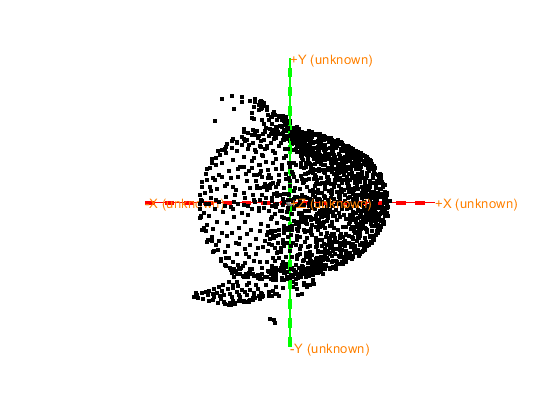

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

In [27]:
ft_determine_coordsys(lasershape, 'interactive', 'no')

Apply a z-plane cut to remove unncessary points from digitized-headshape under a certain z-value.

Use the mouse to rotate the geometry, and click "redisplay" to update the light.
Close the figure when you are done.
the template coordinate system is unknown, selecting the viewpoint is not possible
The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm

Press "h" to show this help.
Press "q" or close the window when you are done.
Press "v" to update the light position.
the call to "ft_interactiverealign" took 4 seconds


ans = logical
   1

ans = logical
   1

keeping 1251 and removing 430 vertices in the mesh
the call to "ft_defacemesh" took 4 seconds


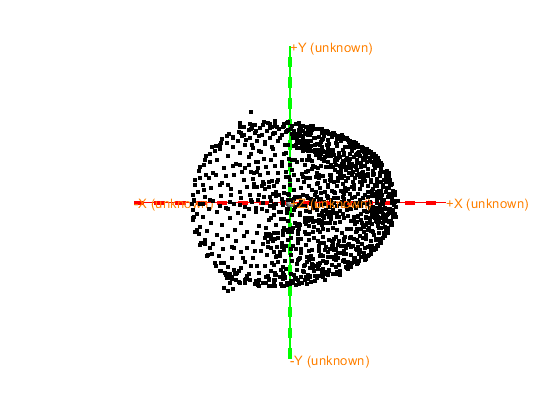

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1251x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'
      cfg: [1x1 struct]

In [37]:
% Deface the laser mesh under a certain plan (change planecut) Define the configuration for ft_defacemesh
planecut = -5;
cfg = [];
cfg.method    = 'plane';       % Use a plane for exclusion
cfg.translate = [0 0 planecut]; % A point on the plane (adjust z_value as needed)
cfg.rotate    = [0 0 0];       % Rotation vector, modify if the plane is not axis-aligned
cfg.selection = 'outside';     % Remove points below the plane

% Apply ft_defacemesh to remove points below the plane
mesh = ft_defacemesh(cfg, lasershape);

% Plot the resulting mesh to check the results
figure
ft_determine_coordsys(mesh, 'interactive', 'no')

When you are happy with the result set your lasershape as the defaced mesh.

In [38]:
lasershape = mesh

lasershape = struct with fields:
      pos: [1251x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'
      cfg: [1x1 struct]

Read subjets MRI T1w scan.

In [41]:
%% read mri and mri-headshape
mri = ft_read_mri(MRI_FILE); % read mri file
MRI_FILE = ft_convert_units(mri, 'mm'); %make sure units mm

extracting compressed dataset to C:\Users\hz3752\AppData\Local\Temp\x2001df3da49bb0c143cbbaaf3ffbe706\...
extracted dataset is located at C:\Users\hz3752\AppData\Local\Temp\x2001df3da49bb0c143cbbaaf3ffbe706\T1


Inspect visually the MRI.

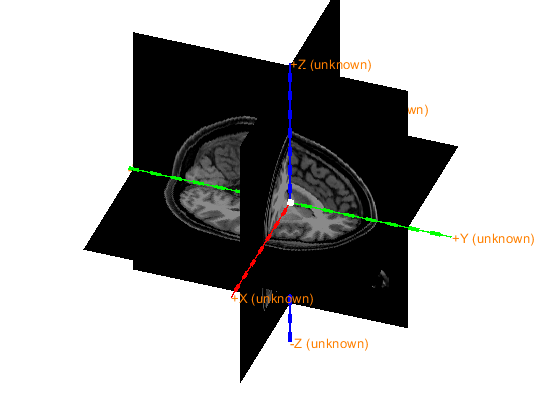

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


In [42]:
mri = ft_determine_coordsys(mri, 'interactive', 'no');

In [ ]:
cfg             = [];
cfg.method      = 'interactive';
cfg.coordsys    = 'ctf'; %use CTF coordinates (pos x toward nose, +y to left)
mri_init = ft_volumerealign(cfg,mri)
ft_determine_coordsys(mri_init, 'interactive', 'no'); % sanity check, should be CTF

save mri_init mri_init

Executing ...